In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score

pd.options.display.max_columns = 500

https://www.scikit-yb.org/en/latest/

### Кластеризация

#### Генерим данные

In [3]:
from sklearn.datasets import make_circles

dataset = make_circles(n_samples=1000,
                       noise=0.1,
                       factor=0.4,
                       random_state=0)

dataset = pd.DataFrame(np.hstack((dataset[0], dataset[1].reshape(-1, 1))),
                       columns=["x1", "x2", "y"])

dataset.head()

,x1,x2,y
0,0.441882,0.020749,1.0
1,0.004388,-0.252644,1.0
2,-0.786777,-0.757186,0.0
3,0.161325,0.254744,1.0
4,-0.275482,0.316769,1.0


#### Изобразим объекты и раскрасим их в классы

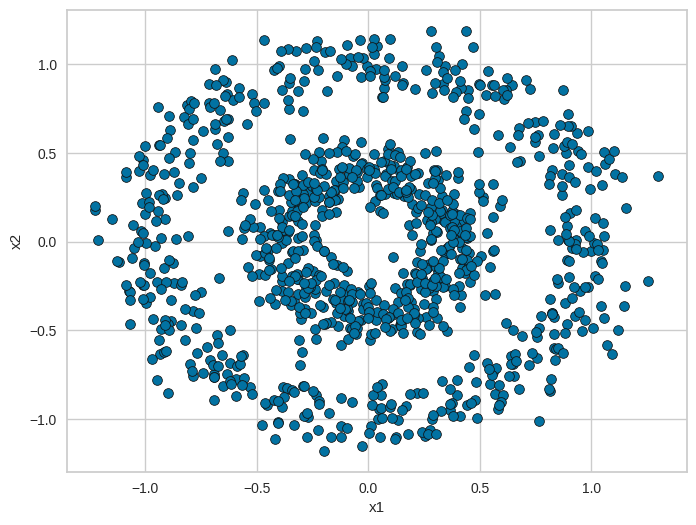

In [6]:
import seaborn as sns

fig = plt.figure()

fig.set_size_inches(8, 6)

sns.scatterplot(x="x1",
                y="x2",
                #hue="y",
                edgecolor="k",
                palette=["#FF5533", "#00B050"],
                data=dataset)

plt.show()

#### K-Means с 2-мя кластерами и разными точками инициализации

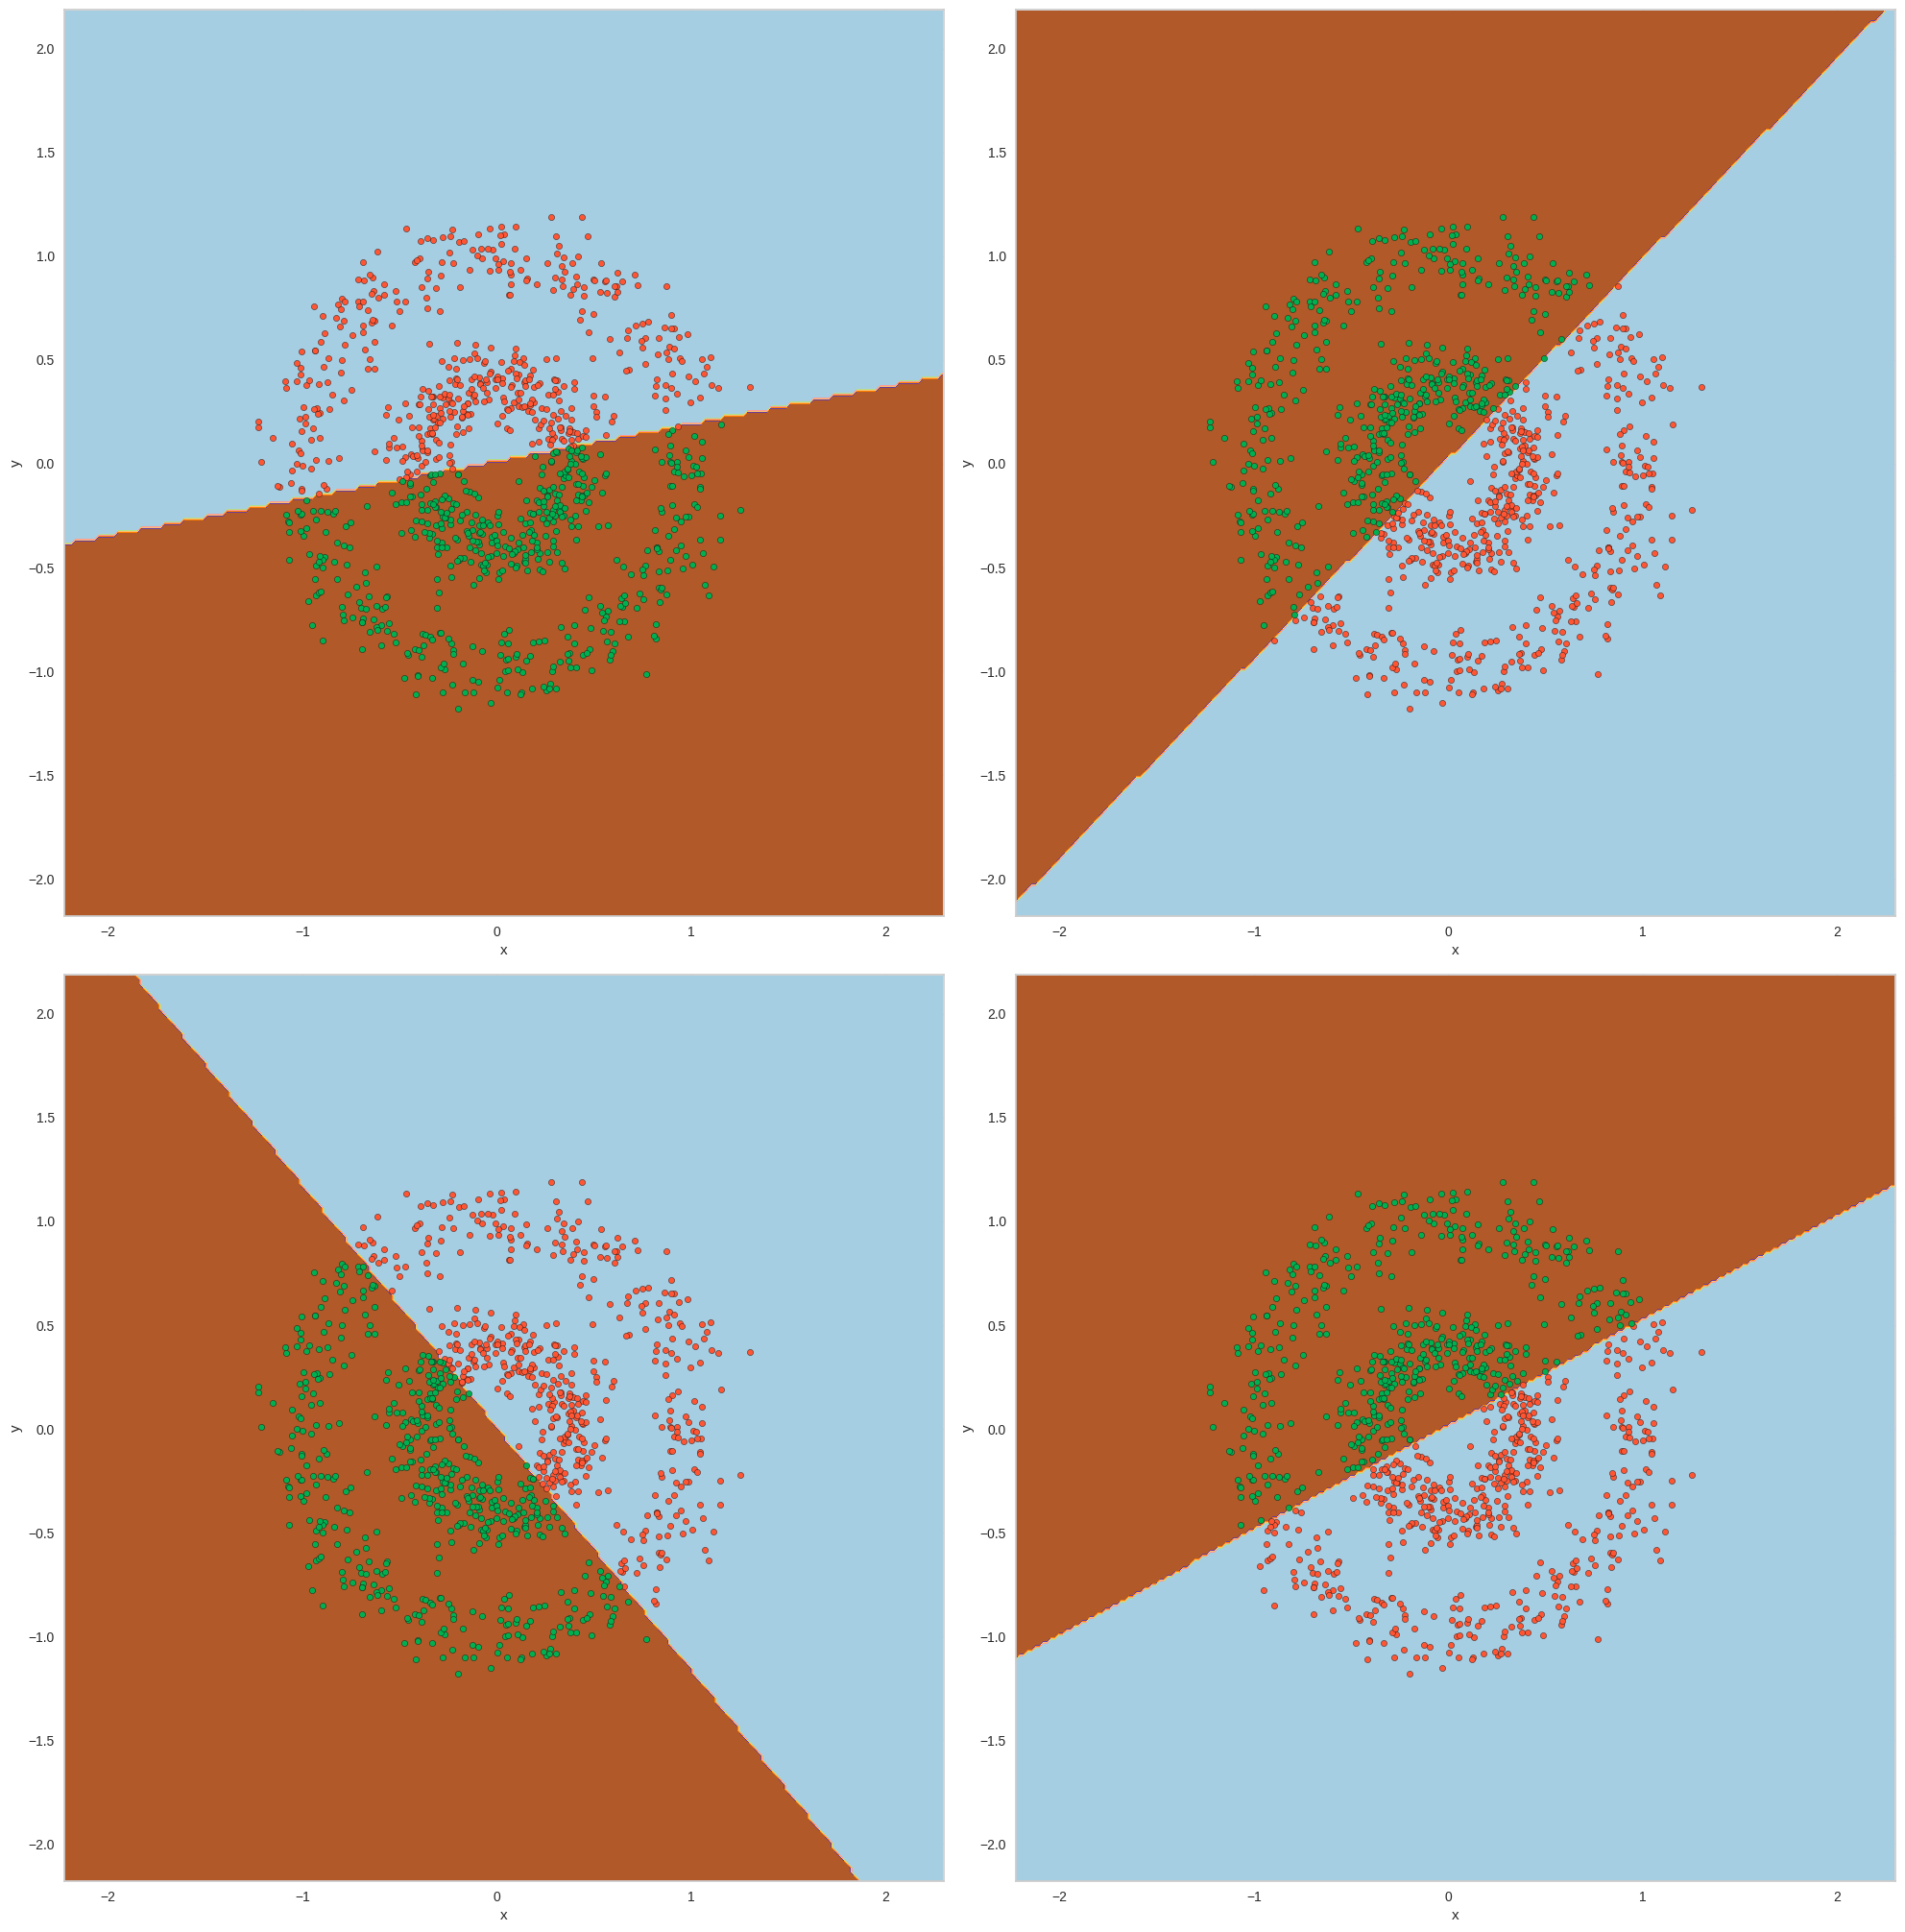

In [7]:
inits = ['random',
         'k-means++',
         np.array([[1, 1],
          [0, 0]]),
         np.array([[1, -2],
          [1, -2]])
        ]

from sklearn.cluster import KMeans

fig = plt.figure()
fig.set_size_inches(20, 50)

for i, s in enumerate(inits):

    X = dataset[["x1", "x2"]]

    kmeans = KMeans(n_clusters=2, init=s, random_state=0).fit(X)
    ax_ = fig.add_subplot(5, 2, i+1)

    pixel_step = 0.02
    x1_min, x1_max = X.values[:, 0].min() - 1, X.values[:, 0].max() + 1
    x2_min, x2_max = X.values[:, 1].min() - 1, X.values[:, 1].max() + 1

    ### Генерим много-много точек на плоскости

    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, pixel_step),
        np.arange(x2_min, x2_max, pixel_step)
    )

    ### Для каждой точки даем прогноз, чтобы покрыть поверхности

    Z = kmeans.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Z = Z.reshape(xx1.shape)

    ### Заполняем пространство

    cs = plt.contourf(xx1, xx2, Z, cmap=plt.cm.Paired)

    plt.axis("tight")

    ### Рисуем точечки и обученные области

    y = kmeans.predict(X)

    for i, c in zip(range(2), ["#FF5533", "#00B050"]):
        idx = np.where(y == i)
        plt.scatter(
            X.values[idx, 0],
            X.values[idx, 1],
            c=c,
            s=20,
            edgecolor="k",
        )
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    plt.xlabel("x")
    plt.ylabel("y")

fig.tight_layout()
plt.show()

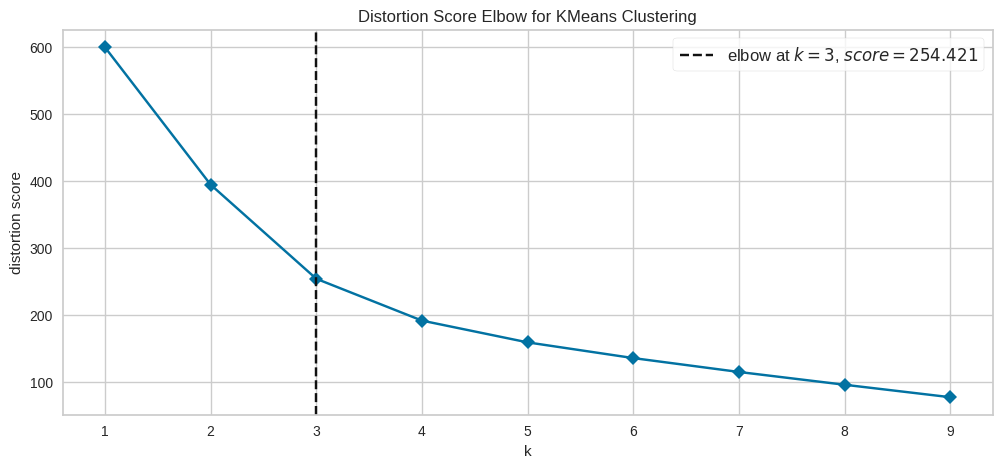

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
X = dataset[["x1", "x2"]]
fig, ax = plt.subplots(figsize=(12,5))
md = KMeans(init='k-means++', n_init=10, max_iter=100)
viz=KElbowVisualizer(md, k=(1,10), ax=ax, timings=False)
viz.fit(X)
viz.show()

In [9]:
for n_clusters in range(2,10):
  clusterer = KMeans(n_clusters=n_clusters, random_state=10)
  cluster_labels = clusterer.fit_predict(X)
  silhouette_avg = silhouette_score(X, cluster_labels)
  print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
      )

For n_clusters = 2 The average silhouette_score is : 0.3201383034788282
For n_clusters = 3 The average silhouette_score is : 0.34566248203437394
For n_clusters = 4 The average silhouette_score is : 0.3298600026305036
For n_clusters = 5 The average silhouette_score is : 0.3006548818999835
For n_clusters = 6 The average silhouette_score is : 0.3394760839706737
For n_clusters = 7 The average silhouette_score is : 0.3373364701399327
For n_clusters = 8 The average silhouette_score is : 0.3887815738605904
For n_clusters = 9 The average silhouette_score is : 0.41101156835255603


#### DBSCAN - разные наборы гиперпараметров, отвечающих за количество соседей у ядровых точек и за размер окрестности

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

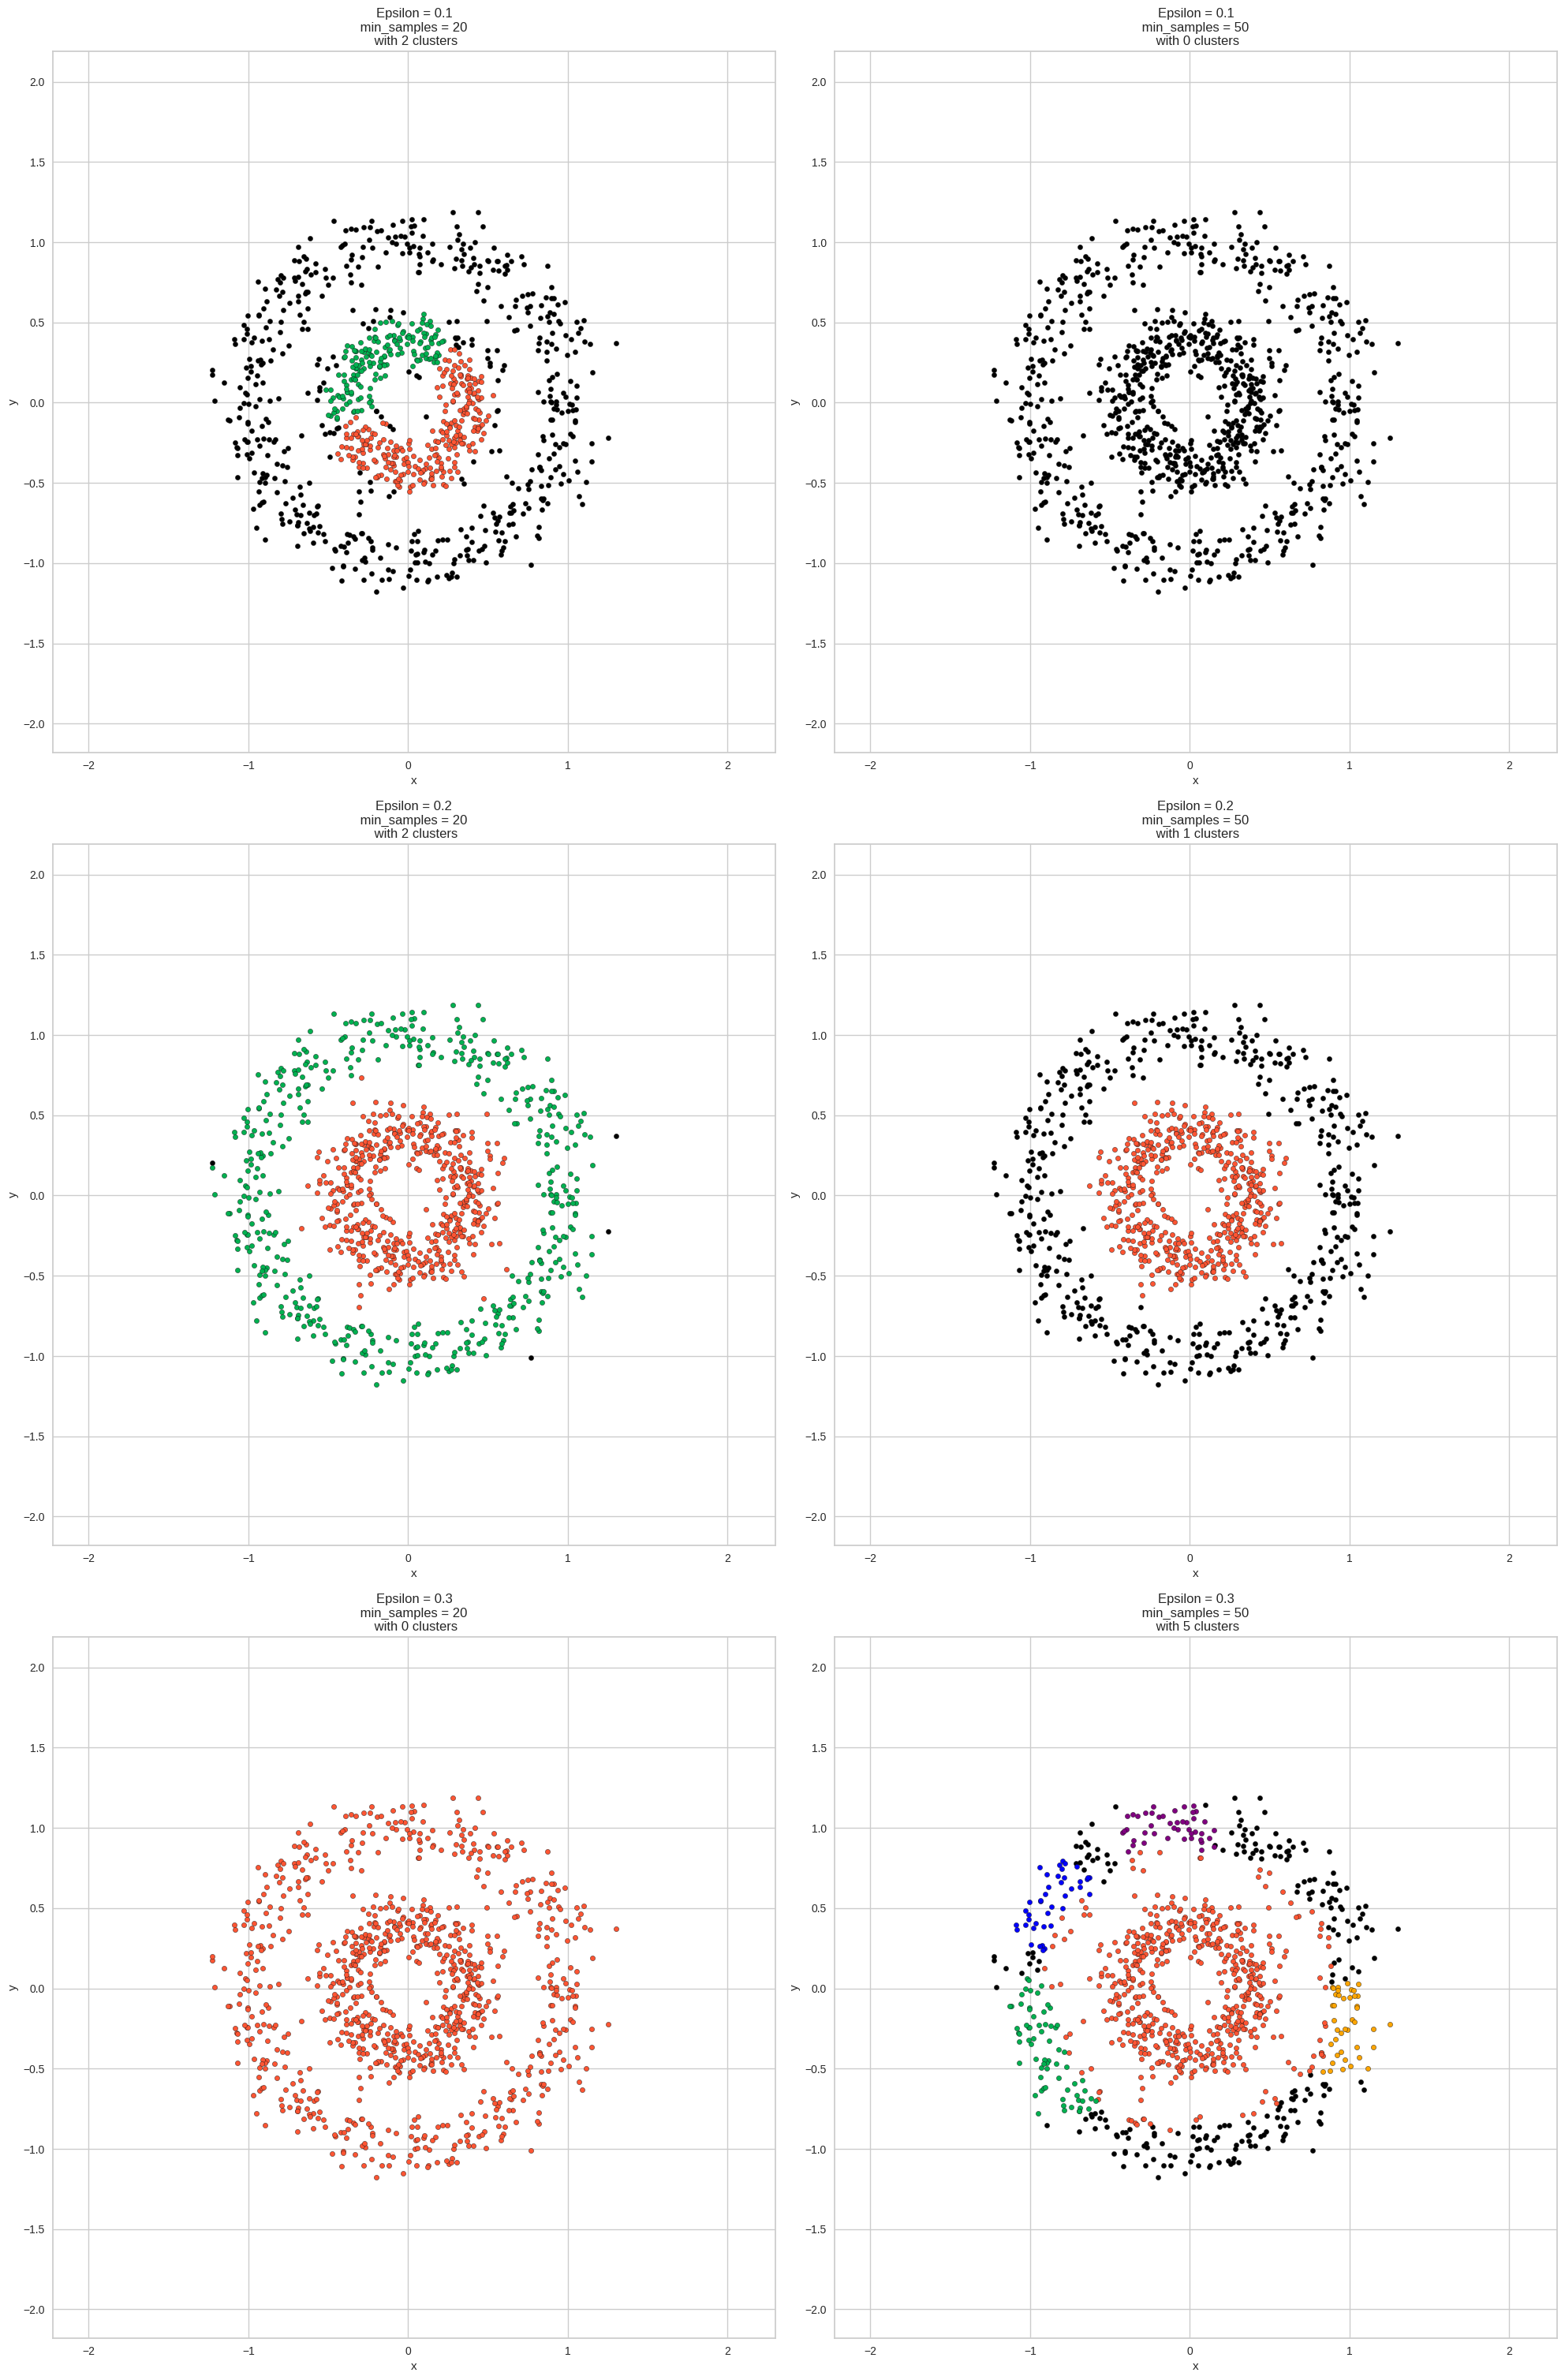

In [10]:
pairs_of_hyperparams = [
                            [0.1,20],
                            [0.1,50],
                            [0.2,20],
                            [0.2,50],
                            [0.3,20],
                            [0.3,50],
                       ]

from sklearn.cluster import DBSCAN

fig = plt.figure()
fig.set_size_inches(20, 50)

for i, s in enumerate(pairs_of_hyperparams):

    X = dataset[["x1", "x2"]]

    dbscan = DBSCAN(eps=s[0], min_samples=s[1]).fit(X)
    ax_ = fig.add_subplot(5, 2, i+1)

    colors = ["black", "#FF5533",
              "#00B050", "orange",
              "blue", "purple"]

    y = dbscan.labels_
    labels = sorted(list(set(dbscan.labels_)))

    if len(labels)==1 and y[0]==0:
        colors = {0:"#FF5533"}
    else:
        colors = dict(zip(labels, colors))


    for i, c in zip(labels, colors.values()):

        idx = np.where(y == i)

        plt.scatter(
            X.values[idx, 0],
            X.values[idx, 1],
            c=c,
            s=20,
            edgecolor="k",
        )
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    plt.xlabel("x")
    plt.ylabel("y")

    if len(y)==1 and y[0]==0:
        n_clusters = 1
    else:
        n_clusters = len(set(y))-1

    plt.title(f"Epsilon = {s[0]}\n min_samples = {s[1]} \n with {n_clusters} clusters")

fig.tight_layout()
plt.show()

### Сегментация клиентов

In [11]:
df = pd.read_excel('processed_segmentation.xlsx')
df.head()

,Age,Work_Experience,Family_Size,Segmentation,Gender_Male,Ever_Married_Yes,Graduated_Yes,Profession_B,Profession_C,Profession_D,Spending_Score_High,Spending_Score_Low,Var_1_B,Var_1_C,Var_1_D
0,22,1.000000,4.0,D,1,0,0,0.075826,0.109610,0.734985,0,1,0.213039,0.100092,0.381084
1,38,2.641663,3.0,A,0,1,1,0.270386,0.107296,0.251788,0,0,0.213039,0.100092,0.381084
2,67,1.000000,1.0,B,0,1,1,0.270386,0.107296,0.251788,0,1,0.234287,0.285472,0.248400
3,67,0.000000,2.0,B,1,1,1,0.253612,0.224719,0.205457,1,0,0.234287,0.285472,0.248400
4,40,2.641663,6.0,A,0,1,1,0.232877,0.155954,0.226554,1,0,0.234287,0.285472,0.248400


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  8068 non-null   int64  
 1   Work_Experience      8068 non-null   float64
 2   Family_Size          8068 non-null   float64
 3   Segmentation         8068 non-null   object 
 4   Gender_Male          8068 non-null   int64  
 5   Ever_Married_Yes     8068 non-null   int64  
 6   Graduated_Yes        8068 non-null   int64  
 7   Profession_B         8068 non-null   float64
 8   Profession_C         8068 non-null   float64
 9   Profession_D         8068 non-null   float64
 10  Spending_Score_High  8068 non-null   int64  
 11  Spending_Score_Low   8068 non-null   int64  
 12  Var_1_B              8068 non-null   float64
 13  Var_1_C              8068 non-null   float64
 14  Var_1_D              8068 non-null   float64
dtypes: float64(8), int64(6), object(1)
mem

In [13]:
X = df.drop('Segmentation', axis=1)
Y = df['Segmentation']

#### PCA преобразование

In [14]:
### Произведем PCA преобразование

from sklearn.decomposition import PCA

X_pca = PCA(n_components=2).fit_transform(X)

X_pca

array([[-21.43286978,  -2.45871976],
       [ -5.45009721,  -0.18593691],
       [ 23.61220116,  -0.70438536],
       ...,
       [-10.36632897,  -1.86499497],
       [-16.43283336,  -2.26716623],
       [ -6.35248649,  -2.86190895]])

In [15]:
X_tsne = np.concatenate((X_pca, Y.values.reshape(-1, 1)),
                               axis=1)

X_tsne = pd.DataFrame(X_tsne, columns=['PCA_1st_component',
                                       'PCA_2nd_component',
                                       'SEGMENT'])

In [16]:
X_tsne

,PCA_1st_component,PCA_2nd_component,SEGMENT
0,-21.43287,-2.45872,D
1,-5.450097,-0.185937,A
2,23.612201,-0.704385,B
3,23.643254,-1.775789,B
4,-3.51823,-0.315505,A
...,...,...,...
8063,-21.465477,-3.649337,D
8064,-8.516026,-0.018887,D
8065,-10.366329,-1.864995,D
8066,-16.432833,-2.267166,B


<Axes: xlabel='PCA_1st_component', ylabel='PCA_2nd_component'>

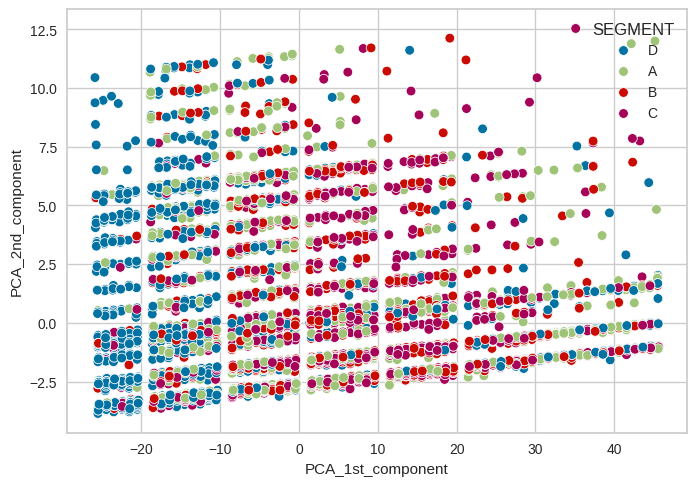

In [17]:
sns.scatterplot(x=X_tsne['PCA_1st_component'], y=X_tsne['PCA_2nd_component'], hue=X_tsne['SEGMENT'])

#### Сегментация KMeans с 4-мя кластерами

In [18]:
kmeans_semg = KMeans(init='random', n_clusters=4).fit(X)
k_means_labels = kmeans_semg.predict(X)

X_pca_with_kmeans_preds = pd.concat(
    (
        X_tsne, pd.DataFrame({"KMEANS label":k_means_labels})
    ),
    axis=1
)

X_pca_with_kmeans_preds.head()

,PCA_1st_component,PCA_2nd_component,SEGMENT,KMEANS label
0,-21.43287,-2.45872,D,0
1,-5.450097,-0.185937,A,1
2,23.612201,-0.704385,B,2
3,23.643254,-1.775789,B,2
4,-3.51823,-0.315505,A,1


Сравним долю совпадения ответов K-Means кластеризации с истинными сегментами

In [20]:
import itertools

accuracies = {}

for perm in itertools.permutations(X_tsne['SEGMENT'].unique()):

    vv = dict(zip(perm, [0, 1, 2, 3]))

    mapping = X_pca_with_kmeans_preds['SEGMENT'].map(vv)
    acc = (mapping == X_pca_with_kmeans_preds['KMEANS label']).mean()

    accuracies[perm] = acc

print(f"{max(accuracies.values())} for {max(accuracies, key=accuracies.get)} combination")

0.4181953396132871 for ('D', 'A', 'B', 'C') combination


In [21]:
real_cluster_names = dict(zip([0, 1, 2, 3], max(accuracies, key=accuracies.get)))
real_cluster_names

{0: 'D', 1: 'A', 2: 'B', 3: 'C'}

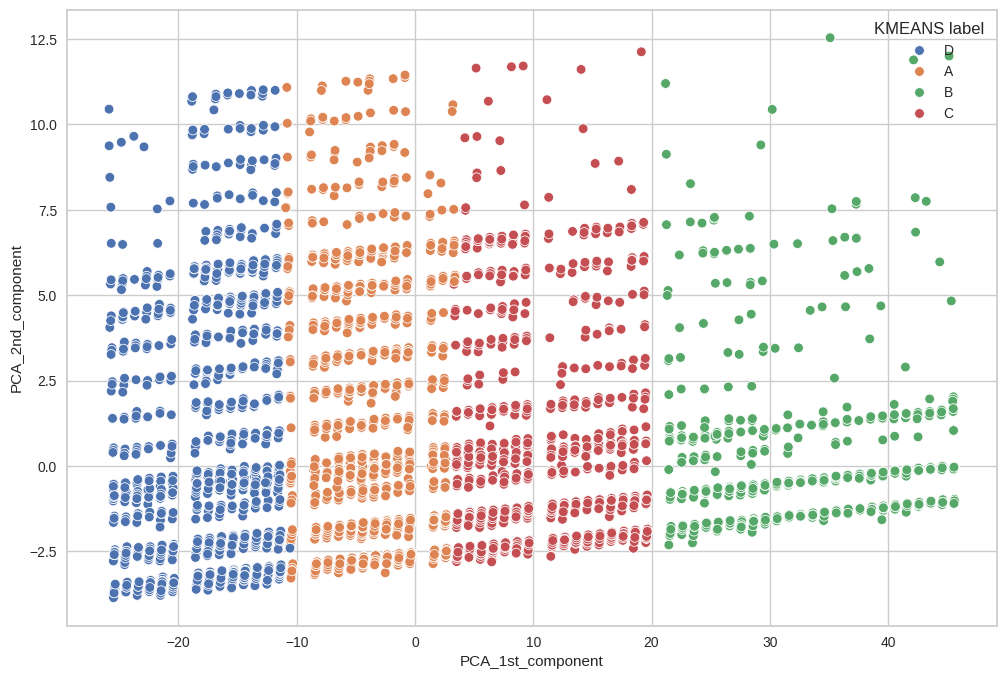

In [22]:
fig = plt.figure()
fig.set_size_inches(12, 8)

X_inv = X_pca_with_kmeans_preds.copy()
X_inv["KMEANS label"] = X_inv["KMEANS label"].map(real_cluster_names)

sns.scatterplot(data=X_inv,
                x="PCA_1st_component",
                y="PCA_2nd_component",
                hue="KMEANS label",
                palette="deep")

plt.show()

In [30]:
dbscan_new = DBSCAN(eps=0.1, min_samples=10).fit(X)

In [24]:
X_pca_with_kmeans_preds = pd.concat(
    (
        X_tsne, pd.DataFrame({"DBSCAN label":dbscan_new.labels_})
    ),
    axis=1
)
X_pca_with_kmeans_preds.head()

,PCA_1st_component,PCA_2nd_component,SEGMENT,DBSCAN label
0,-21.43287,-2.45872,D,-1
1,-5.450097,-0.185937,A,-1
2,23.612201,-0.704385,B,-1
3,23.643254,-1.775789,B,-1
4,-3.51823,-0.315505,A,-1


In [31]:
X_pca_with_kmeans_preds['DBSCAN label'].value_counts()

,count
DBSCAN label,
-1,8068
